### Plot the b.o.a. labels over the highet map

In [1]:
import numpy as np 
import nevis 
import basin

def find_labels(h):
    maxima, sn = basin.find_maxima(h)
    label, _ = basin.find_basins(h, sn, maxima)
    return label, maxima
data = nevis.gb()

A small sample testing our algorithm:

In [2]:
test_data = np.array([
    [1, 2, 3, 8, 10],
    [3, 4, 6, 7, 5],
    [5, 2, 7, 8, 9],
    [1, 6, 11, 10, 4],
    [2, 4, 3, 1, 5],
])
label, maxima = find_labels(test_data)
label

Progress of labelling: 0 5


array([[0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int32)

In [3]:
maxima

array([[3, 2],
       [0, 4]], dtype=int32)

Let's do the plotting now. We can't plot it on the entire map, so let's introduce two methods to truncate the map to a small section.
1. The surrounding of the highest point of the map.
2. Based on the square name e.g. NY31

In [4]:

def get_part(data, size):
    """
    Get the the s times s surrounding of the highest point in
    the 2d matrix data, 
    where s = size if size is odd and size+1 if size is even.
    """
    m, n = data.shape
    # find the largest entry index in the matrix
    # this is the index in the flattened 1d array of data
    max_idx = np.argmax(data)
    size //= 2
    # we have to do the maths
    part = data[max_idx // n - size: max_idx // n +
                size + 1, max_idx % n - size: max_idx % n + size + 1]
    return part

In [5]:
get_part(data, 5)

array([[1338.9, 1337.2, 1333.9, 1322.7, 1310.8],
       [1333.3, 1343.1, 1342.1, 1340.9, 1335.7],
       [1255.8, 1339.6, 1345.3, 1343.8, 1342.8],
       [1203.9, 1222.5, 1299.1, 1327.7, 1311.7],
       [1172.1, 1183. , 1227.9, 1281. , 1240.9]], dtype=float32)

In [6]:
def get_square(square):
    coords, size = nevis.Coords.from_square_with_size(square)
    x, y = coords.grid
    x //= 50
    y //= 50
    size //= 50
    return data[y:y+size, x:x+size]

In [7]:
get_square("NY31")

array([[366.7, 351.7, 347.5, ..., 462.6, 461.1, 437.8],
       [383.5, 380.8, 378.5, ..., 438.8, 439.9, 418.8],
       [398.8, 402.3, 407.3, ..., 408. , 413.4, 397.6],
       ...,
       [316.3, 311.4, 299.9, ..., 154.8, 153.7, 153.3],
       [288.4, 285. , 267.9, ..., 161. , 159.5, 157.7],
       [268.3, 251. , 233.7, ..., 165.9, 164. , 161.8]], dtype=float32)

In [8]:
import random

vmin = np.min(data)
vmax = np.max(data)

def plot_label(h, label=None, maxima=None, show_max_num=None, alpha=0.5):
    """
    Plot the label for b.o.a. over the height map.
    h: numpy 2d array for heights
    label: numpy 2d array for b.o.a. labels. Will be calculated if None
    maxima: numpy 1d array for list of local maxima. Will be calculated if None
    show_max_num: the number of the highest local maxima and their b.o.a to be shown
    alpha: the transparency of the overlay of the b.o.a.
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors

    if label is None or maxima is None:
        label, maxima = find_labels(h)

    def f(x): return (x - vmin) / (vmax - vmin)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'soundofmusic', [
            (0, '#4872d3'),             # Deep sea blue
            (f(-0.1), '#68b2e3'),       # Shallow sea blue
            (f(0.0), '#0f561e'),        # Dark green
            (f(10), '#1a8b33'),         # Nicer green
            (f(100), '#11aa15'),        # Glorious green
            (f(300), '#e8e374'),        # Yellow at ~1000ft
            (f(610), '#8a4121'),        # Brownish at ~2000ft
            (f(915), '#999999'),        # Grey at ~3000ft
            (1, 'white'),
        ], N=1024)

    plt.imshow(
        h,
        origin='lower',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        interpolation='none',
    )

    if show_max_num is not None:
        label[label >= show_max_num] = show_max_num

    num_colors = len(np.unique(label))
    cmap = plt.get_cmap('gist_ncar', num_colors)
    indices = list(range(num_colors))
    random.seed(12138)
    random.shuffle(indices)
    cmap_object = matplotlib.colors.ListedColormap([cmap(i) for i in indices])

    plt.imshow(
        label,
        origin='lower',
        # cmap='tab20',
        cmap=cmap_object,
        interpolation='none',
        alpha=alpha,
    )

    if show_max_num is not None:
        x, y = maxima[:show_max_num].T
    else:
        x, y = maxima.T

    plt.scatter(y[1:], x[1:], c='purple', s=50, marker='x')
    plt.scatter(y[:1], x[:1], c='red', s=50, marker='x')
    plt.show()
    # plt.savefig('out.png')

Progress of labelling: 0 101
Progress of labelling: 100 101


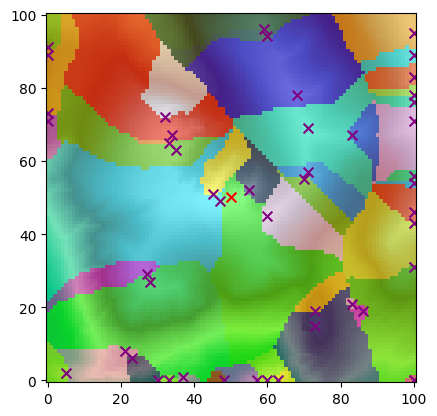

In [9]:
part = get_part(data, 101)
plot_label(part)

Notice: we have calculated the labels for this truncation, instead of truncating the labels for the entire map. The difference is that there will be some local maxima on the edge (as above) that are not local maxima on the entire map.